## Zimnat Insurance Product Recommendation Challenge

In [1]:
#Importing all the Required Libraries

import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer,f1_score,log_loss
import xgboost as xgb

#Setting Random State
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)


#Installing optuna - Only for Google Collab Environment
#!pip install optuna


C:\Users\Darrel\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Importing the data to pandas DataFrame
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
print("Training Set dimesions: ",df_train.shape)
print("Test Set dimesions: ",df_test.shape)

Training Set dimesions:  (29132, 29)
Test Set dimesions:  (10000, 29)


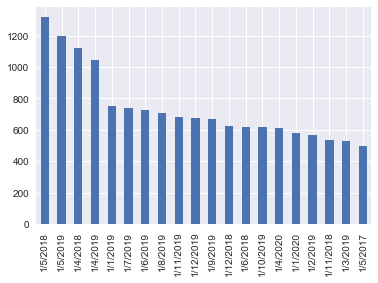

In [4]:
#Checking for Missing Values
df_train['join_date'].value_counts().sort_values(ascending=False).head(20).plot(kind="bar")

In [5]:
#checking for the most common date and imputing by most common
df_train['join_date'].fillna(df_train['join_date'].mode()[0],inplace=True,axis=0)
df_test['join_date'].fillna(df_test['join_date'].mode()[0],inplace=True)

In [6]:
#Checking the number of Categories for Categorical Columns

for cols in df_train.columns:
    if df_train[cols].dtype == "O" and (cols not in ["ID","join_date"]):
        print("Variable:",cols," Number of Categories:",len(df_train[cols].value_counts()))

Variable: sex  Number of Categories: 2
Variable: marital_status  Number of Categories: 8
Variable: branch_code  Number of Categories: 15
Variable: occupation_code  Number of Categories: 233
Variable: occupation_category_code  Number of Categories: 6


In [7]:
#One-hot encoding for categories where we do not have many categories
cols = ['sex','marital_status','branch_code','occupation_category_code']
df_train = pd.get_dummies(df_train ,columns = cols,prefix=cols)
df_test= pd.get_dummies(df_test ,columns = cols,prefix=cols)

#Feature Engineering ------- Creating additional features

for df in [df_train,df_test]:
    df['day_joined'] = pd.DatetimeIndex(df['join_date']).day
    df['month_joined'] = pd.DatetimeIndex(df['join_date']).month
    df['year_joined'] = pd.DatetimeIndex(df['join_date']).year
    df['Age_at_join'] = df['year_joined'] - df['birth_year']
    df['time_elapsed_joined'] = (pd.to_datetime('08/01/2020') - pd.DatetimeIndex(df['join_date'])).days
    df.drop(columns='join_date',inplace=True)
    
    
# We will only encode the top 95% of categories for the occupation code as there are too may categories to do one-hot
value_cum = df_train.occupation_code.value_counts().sort_values(ascending=False).cumsum()/df_train.shape[0]
topn_encode = value_cum[value_cum < 0.95]

topn = list(topn_encode.index)

for df in [df_train,df_test]:
    for categories in topn:
        df['occupation_code_'+categories] = np.where(df['occupation_code']==categories,1,0)
    df.drop(columns='occupation_code',inplace=True)

C:\Users\Darrel\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


In [9]:
print("Training Set dimesions: ",df_train.shape)
print("Test Set dimesions: ",df_test.shape)

Training Set dimesions:  (29132, 110)
Test Set dimesions:  (10000, 110)


In [10]:
# Setting up the dataset for use in the model
product_cols = ['P5DA', 'RIBP', '8NN1', '7POT','66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 
                'AHXO', 'BSTQ','FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']

#Converting product to numeric label
product_ref = dict()
for i,x in enumerate(product_cols):
    product_ref[x] = i

In [11]:
#Converting the dataframe to duplicate observations across different products for the same ID
transpose_df = pd.melt(df_train,id_vars=['ID'],value_vars=product_cols).sort_values('ID')
transpose_df = transpose_df.loc[transpose_df.value ==1]

#Merging to main training set
merged_df = pd.merge(df_train, transpose_df, on='ID', how='left')

#Where target product in row, setting the value for product to zero
def Replace_Targets(df):
    for product in product_cols:
        if df[product] == 1 and df['variable'] == product:
            df[product] = 0
        
    return df  

merged_df = merged_df.apply(Replace_Targets,axis=1)

#Cleaning up and remapping products to numeric values
merged_df.rename(columns={'variable':'Target'},inplace=True)
merged_df.drop(columns=['value'],inplace=True)
merged_df['Target'] = merged_df['Target'].map(product_ref)

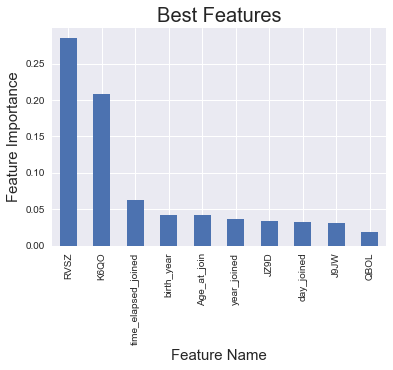

In [48]:
#Feature selection using RandomForestClassifer
Best_Features = RandomForestClassifier().fit(merged_df.drop(columns = ["ID","Target"]),merged_df.Target).feature_importances_

#Creating X and Y dataframes
X = merged_df.drop(columns = ["ID","Target"])
y = merged_df.Target

# Selecting the TopN Features --- Feature Selection

combined = dict(zip(X.columns,Best_Features))
FI = pd.Series(combined)


FI.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Best Features',fontsize=20)
plt.xlabel('Feature Name',fontsize=15)
plt.ylabel('Feature Importance',fontsize=15)


BF = list(FI.sort_values(ascending=False).head(10).index)


In [54]:
#Checking the distribution of classes
merged_df['Target'].value_counts().sort_values(ascending=False)

7     25328
14    21629
15     6833
8      2173
1      1780
17     1425
18     1418
20     1102
19      902
10      838
11      539
6       431
9       354
4       339
12      324
3       316
16      311
2       157
13      110
0        40
5         4
Name: Target, dtype: int64

In [139]:
# Oversampling classes using SMOTE
from imblearn.over_sampling import SMOTE
desired_classes = {5:50,0:100,13:200,2:300,19:3000,4:700,6:800,3:700}
sm = SMOTE(random_state=RANDOM_STATE,sampling_strategy=desired_classes,k_neighbors=3)
X_res,y_res = sm.fit_resample(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [141]:
# Training the model

import xgboost as xgb

#Splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=RANDOM_STATE)

#Fitting the Model
params = {'objective':'multi:softprob','num_class':21,'max_depth': 9, 
          'eta': 0.20, 'booster': 'dart', 'reg_lambda': 30,
          'colsample_bytre': 0.35 ,'subsample': 0.85,'eval_metric':'mlogloss','n_threads':2}
num_boost_round=999
early_stopping=10


dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

evals = [(dtrain,'Train'),(dtest,'Test')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping
    )

[0]	Train-mlogloss:1.75072	Test-mlogloss:1.75657
Multiple eval metrics have been passed: 'Test-mlogloss' will be used for early stopping.

Will train until Test-mlogloss hasn't improved in 10 rounds.
[1]	Train-mlogloss:1.46651	Test-mlogloss:1.47586
[2]	Train-mlogloss:1.26797	Test-mlogloss:1.2805
[3]	Train-mlogloss:1.11963	Test-mlogloss:1.1343
[4]	Train-mlogloss:1.00351	Test-mlogloss:1.02084
[5]	Train-mlogloss:0.909045	Test-mlogloss:0.928553
[6]	Train-mlogloss:0.832306	Test-mlogloss:0.853924
[7]	Train-mlogloss:0.768725	Test-mlogloss:0.792328
[8]	Train-mlogloss:0.715646	Test-mlogloss:0.741391
[9]	Train-mlogloss:0.670223	Test-mlogloss:0.69799
[10]	Train-mlogloss:0.63206	Test-mlogloss:0.661777
[11]	Train-mlogloss:0.599564	Test-mlogloss:0.631162
[12]	Train-mlogloss:0.571653	Test-mlogloss:0.605169
[13]	Train-mlogloss:0.547763	Test-mlogloss:0.583052
[14]	Train-mlogloss:0.52667	Test-mlogloss:0.563929
[15]	Train-mlogloss:0.508472	Test-mlogloss:0.547309
[16]	Train-mlogloss:0.492097	Test-mlogloss

In [143]:
#Saving the model
import pickle
file_name = "/content/drive/My Drive/Models/XGBOOST0-379144LL.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

In [ ]:
#Load Model
import pickle
file_name = "/content/drive/My Drive/Models/xgb-boostingS1.pkl"
model = pickle.load( open(file_name, "rb"))

In [144]:
# --------- PIPELINE FOR PREDICTION AND CREATING SUBMISSION FILES ----------#

#Making predictions of Test Set
X_test1 = df_test.drop(columns=['ID'])[BF].to_numpy()
final_test = xgb.DMatrix(X_test1)
pred_prob = model.predict(final_test,ntree_limit=159)

In [145]:
def submission(predict_prob,classes,df_test):
    ''' Creates Submission Files from 
        Probability Outputs, Product names list and 
        Test file for ID and existing product Extraction'''
    
    #ID Counter
    counter = 0
    #Output dictionary
    output = {'ID X PCODE':[],'Label':[]}

    #Iterating over ID values in test data
    for idd in df_test['ID'].values:
        #Iterating over all probabilities per row
        for i,prob in enumerate(predict_prob[counter]):
            # Setting product name 
            product_name = classes[i]
            #Checking if current ID already has product, and set prob = 1 if so
            if df_test.loc[df_test['ID']==idd,product_name].values[0] == 1:
                prob = 1
            output['ID X PCODE'] = output['ID X PCODE'] + [str(idd) + " X " + str(product_name)]
            output['Label'] = output['Label'] + [prob]
        counter += 1
    return output

output = submission(pred_prob,product_cols,df_test)

In [146]:
df_submission = pd.DataFrame.from_dict(output)
df_submission.to_csv("Submission_15.csv",index=False)

In [147]:
pd.read_csv("Submission_15.csv").head(50)

,ID X PCODE,Label
0,F86J5PC X P5DA,0.000020
1,F86J5PC X RIBP,0.000158
2,F86J5PC X 8NN1,0.000009
3,F86J5PC X 7POT,0.000061
4,F86J5PC X 66FJ,0.000051
5,F86J5PC X GYSR,0.000016
6,F86J5PC X SOP4,0.000073
7,F86J5PC X RVSZ,1.000000
8,F86J5PC X PYUQ,0.000515
9,F86J5PC X LJR9,0.000020
